In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 读取数据集：no-filter数据、ground-truth数据集、运动控制U、测量集合Z
X_no_filter = np.load('./dataset/no_filter.npy')
X_ground_truth = np.load('./dataset/ground_truth.npy')
X_ekf = np.load('./dataset/ekf.npy')
U = np.load('./dataset/u.npy')
Z = np.load('./dataset/z.npy')

# 扩展信息滤波算法


----
1：**Algorithm Extended_information_filter**$( \xi_{t-1}, \Omega_{t-1}, u_t, z_t )$**:**  

2：&emsp;&emsp;$\mu_{t-1} = \Omega_{t-1}^{-1} \xi_{t-1}$  

3：&emsp;&emsp;$\bar{\Omega}_t = (G_t \Omega_{t-1}^{-1} G_t^T + R_t)^{-1}$  

4：&emsp;&emsp;$\bar{\xi}_t = \bar{\Omega}_t g(u_t, \mu_{t-1})$    

5：&emsp;&emsp;$\bar{\mu}_t = g(u_t, \mu_{t-1})$  

6：&emsp;&emsp;$\Omega_t = \bar{\Omega}_t + H_t^T Q_t^{-1} H_t$  

7：&emsp;&emsp;$\xi_t = \bar{\xi}_t + H_t^T Q_t^{-1} [ z_t - h(\bar\mu_t) + H_t \bar\mu_t]$  

8：&emsp;&emsp;**return** ${\xi_t, \Omega_t}$  

----


In [3]:
# 运动迁移函数的Jacobi矩阵
def jacobian_G(mu, u):
    x, y, theta = np.squeeze(mu)
    G = np.eye(3,dtype=np.float64)
    G[0][2] = - u * np.sin(theta)
    G[1][2] = u * np.cos(theta)
    return G

In [4]:
# 测量方程的雅可比矩阵
def jacobian_H(mu):
    x, y, theta = np.squeeze(mu)
    distance = np.sqrt(x ** 2 + y ** 2)
    H = np.array([x/distance, y / distance, 0, 0, 0, 1]).reshape((2, 3))
    return H

In [5]:
# 运动迁移函数g
def state_transfer_function(mu, u):
    x0, y0, theta0 = np.squeeze(mu)
    x1 = x0 + u * np.cos(theta0)
    y1 = y0 + u * np.sin(theta0)
    theta1 = theta0
    if theta1 > np.pi:
        theta1 =theta1 - 2 * np.pi
    elif theta1 < -np.pi:
        theta1 = theta1 + 2 * np.pi
    return np.array([x1, y1, theta1]).reshape((3, 1))

In [6]:
# 测量函数h
def measurement_function(mu):
    x0, y0, theta0 = np.squeeze(mu)
    z1 = np.sqrt(x0 ** 2 + y0 ** 2)
    z2 = theta0
    return np.array([z1, z2]).reshape((2,1))

In [7]:
# 扩展信息滤波算法
# 默认运动控制误差为0.25，观测误差为0.1
def extended_information_filter(xi_previous, Omega_previous, u, z, sigma_u=0.25, sigma_z=0.1):
    # 修正输入参数的维度
    xi_previous = np.array(xi_previous).reshape((3, 1))
    z = np.array(z).reshape((2,1))
    
    # 控制方程和测量方程的误差协方差矩阵
    R = np.eye(3, dtype=np.float64) * sigma_u ** 2
    Q = np.eye(2, dtype=np.float64) * sigma_z ** 2
    
    # line 2
    mu_previous = np.dot(np.linalg.inv(Omega_previous), xi_previous)
    
    # line 3
    G = jacobian_G(mu_previous, u)
    Omega_previous_inverse = np.linalg.inv(Omega_previous)
    Omega_predict = np.linalg.inv(np.dot(np.dot(G, Omega_previous_inverse), G.T) + R)
    
    # line 4
    xi_predict = np.dot(Omega_predict, state_transfer_function(mu_previous, u))
    
    # line 5
    mu_predict = state_transfer_function(mu_previous, u)
    
    # line 6
    H = jacobian_H(mu_predict)
    Q_inverse = np.linalg.inv(Q)
    Omega_update = Omega_predict + np.dot(np.dot(H.T, Q_inverse), H)
    
    # line 7
    xi_update = xi_predict + np.dot(np.dot(H.T, Q_inverse), (z - measurement_function(mu_predict) + np.dot(H, mu_predict)))
    
    return xi_update, Omega_update

In [8]:
Omegas = []
# 设定初始的位姿和初始的协方差
X_eif = np.array([0, 0, np.pi / 4]).reshape((1,3))
omega = np.diag([ 100, 100, 100])
XI_eif = np.dot(omega, X_eif.T).T
Omegas.append(omega)

for u, z in zip(U, Z):
    xi, omega = extended_information_filter(XI_eif[-1], Omegas[-1], u, z,
                                            sigma_u=0.2, sigma_z=0.1)
    mu = np.dot(np.linalg.inv(omega), xi)
    X_eif = np.vstack([X_eif, mu.T])
    XI_eif = np.vstack([XI_eif, xi.T])
    Omegas.append(omega)

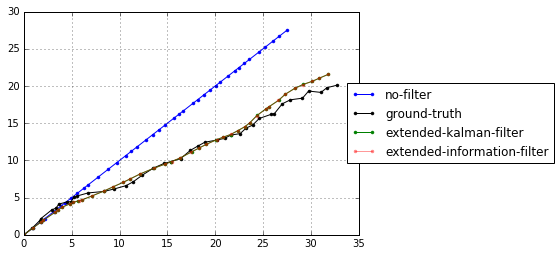

In [17]:
left  = 0
right = 40
marker = '.'
fig, ax = plt.subplots()
ax.plot(X_no_filter[left:right,0], X_no_filter[left:right,1], 
        c='b',marker=marker, label='no-filter')
ax.plot(X_ground_truth[left:right,0], X_ground_truth[left:right,1], 
        c='k',marker=marker, label='ground-truth')
ax.plot(X_ekf[left:right,0], X_ekf[left:right,1], 
        c='g',marker=marker, label='extended-kalman-filter')
ax.plot(X_eif[left:right,0], X_eif[left:right,1], alpha=0.4,
        c='r',marker=marker, label='extended-information-filter')
ax.legend(bbox_to_anchor=(1.6, 0.5), loc='center right')
ax.grid()

扩展信息滤波是扩展卡尔曼滤波的信息形式，因此在计算结果上与结果相似。

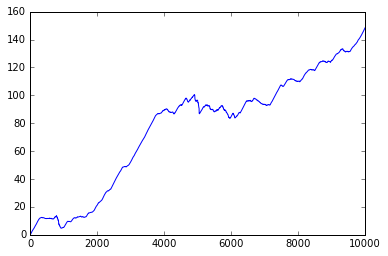

In [25]:
# 协方差特征值的变化
es = [np.max(e) for e, v in [np.linalg.eig(np.linalg.inv(omega)) for omega in Omegas]]
plt.plot(es)

efk: 4.23133143066
eif: 4.56389256468


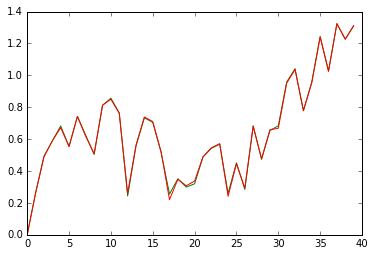

In [35]:
distance_eif = np.sqrt(np.linalg.norm((X_eif - X_ground_truth)[:,:2], axis=1, ord=2, keepdims=True))
distance_ekf = np.sqrt(np.linalg.norm((X_ekf - X_ground_truth)[:,:2], axis=1, ord=2, keepdims=True))
plt.plot(distance_ekf[:40], c='g', )
plt.plot(distance_eif[:40], c='r')
print("efk:", np.sum(distance_ekf)/len(distance_ekf))
print("eif:", np.sum(distance_eif)/len(distance_eif))